In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Layer

In [2]:
path = r"C:\Users\User\Documents\Python Scripts\bangla_local_language_data - Sheet1 (1).csv"

In [3]:
df=pd.read_csv(path)
print(df)

                                         Modern Bangla  \
0                                  আমি আপনাকে ঘৃণা করি   
1                                  আমি তোমায় ভালোবাসি   
2                               আমি তোমার প্রেমে পড়েছি   
3                                           আমি দুঃখিত   
4                                      আমি খুবই দুঃখিত   
...                                                ...   
3468                          বেশি গর্ব সর্বনাশের কারণ   
3469  অতি পরিচিত লোক গুণী হলেও উপযুক্ত মর্যাদা পায় না   
3470               অসৎ উপায়ে অর্জিত ধন অকাজে নষ্ট হয়   
3471              খারাপ কিছু থাকার চেয়ে না থাকাই ভালো   
3472                      অপচয় করবে না এবং অভাব হবে না   

                     Sylheti  Total Needed  Total Translated  
0     আমি আপনারে বালা পাই না        3473.0             647.0  
1        আমি তোমারে বালা পাই           NaN               NaN  
2     আমি তোমার বালা পাইলিছি           NaN               NaN  
3            আমার বুল অইগেছে           NaN         

In [4]:
df=df.drop(["Total Needed", "Total Translated"], axis=1)

In [5]:
df=df.dropna()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 647 entries, 0 to 3251
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Modern Bangla  647 non-null    object
 1   Sylheti        647 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [7]:
old_column_name = 'Modern Bangla'
new_column_name = 'Bangla'
df.rename(columns={'Modern Bangla': 'Bangla'}, inplace=True)

In [8]:
df['Bangla'] = df['Bangla'].astype(str)
df['Sylheti'] = df['Sylheti'].astype(str)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 647 entries, 0 to 3251
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Bangla   647 non-null    object
 1   Sylheti  647 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [10]:
# Custom Attention Layer
class Attention(Layer):
    def __init__(self, return_sequences=True):
        super(Attention, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        return tf.keras.backend.sum(output, axis=1)

In [11]:
# Assuming your CSV has 'local_language' and 'original_bangla' columns
X = df['Sylheti'].astype(str)
y = df['Bangla'].astype(str)

In [12]:
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = max(len(seq) for seq in X_train_seq + X_test_seq)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [13]:
# Tokenize and pad y_train (target sequences)
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(y_train)

y_train_seq = y_tokenizer.texts_to_sequences(y_train)
y_test_seq = y_tokenizer.texts_to_sequences(y_test)

y_train_padded = pad_sequences(y_train_seq, maxlen=max_len, padding='post')
y_test_padded = pad_sequences(y_test_seq, maxlen=max_len, padding='post')

In [14]:
# Define the BiLSTM model with attention mechanism
model = Sequential()
model.add(Embedding(vocab_size, 256, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(512, return_sequences=True)))
model.add(Attention())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(vocab_size, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model for 20 epochs without early stopping
history = model.fit(
    X_train_padded,
    y_train_padded,
    epochs=20,
    batch_size=64,
    validation_split=0.1
)

Epoch 1/20


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\layer.py:877: UserWarning: Layer 'attention' (of type Attention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.6233 - loss: 7.1136 - val_accuracy: 0.6308 - val_loss: 7.0742
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.6239 - loss: 7.0572 - val_accuracy: 0.6308 - val_loss: 6.9890
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.6237 - loss: 6.9501 - val_accuracy: 0.6308 - val_loss: 6.7169
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.6269 - loss: 6.5804 - val_accuracy: 0.6308 - val_loss: 6.3509
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.6241 - loss: 6.2646 - val_accuracy: 0.6436 - val_loss: 6.2038
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.6402 - loss: 6.0780 - val_accuracy: 0.6436 - val_loss: 6.0118
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.6410 - loss: 5.8262 - val_accuracy: 0.6436 - val_loss: 5.7726
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.6343 - loss: 5.5262 - val_accuracy: 0.6436 - val_loss: 5.5048
Epo

In [15]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test_padded, y_test_padded)
print(f"Test Accuracy: {accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7395 - loss: 1.7003
Test Accuracy: 0.7364102005958557


In [16]:
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 15, 256)        │       317,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 15, 1024)       │     3,149,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 15, 1024)       │         1,039 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15, 512)        │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15, 1240)       │       636,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,887,671 (52.98 MB)

 Trainable params: 4,629,223 (17.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,258,448 (35.32 MB)

In [17]:
# Tokenize and pad validation data (for evaluation metrics)
X_val_seq = tokenizer.texts_to_sequences(X_test)  # Use test data for validation
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

# Predict on validation data
y_val_pred_prob = model.predict(X_val_padded)
y_val_pred_indices = np.argmax(y_val_pred_prob, axis=-1)

# Compute evaluation metrics
accuracy = accuracy_score(y_test_padded.flatten(), y_val_pred_indices.flatten())
precision = precision_score(y_test_padded.flatten(), y_val_pred_indices.flatten(), average='weighted')
recall = recall_score(y_test_padded.flatten(), y_val_pred_indices.flatten(), average='weighted')
f1 = f1_score(y_test_padded.flatten(), y_val_pred_indices.flatten(), average='weighted')
cm = confusion_matrix(y_test_padded.flatten(), y_val_pred_indices.flatten())

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
#print("Test Confusion Matrix:")
#print(cm)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
Test Accuracy: 0.7364102564102564
Test Precision: 0.6332021894716258
Test Recall: 0.7364102564102564
Test F1 Score: 0.6763094653728171


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


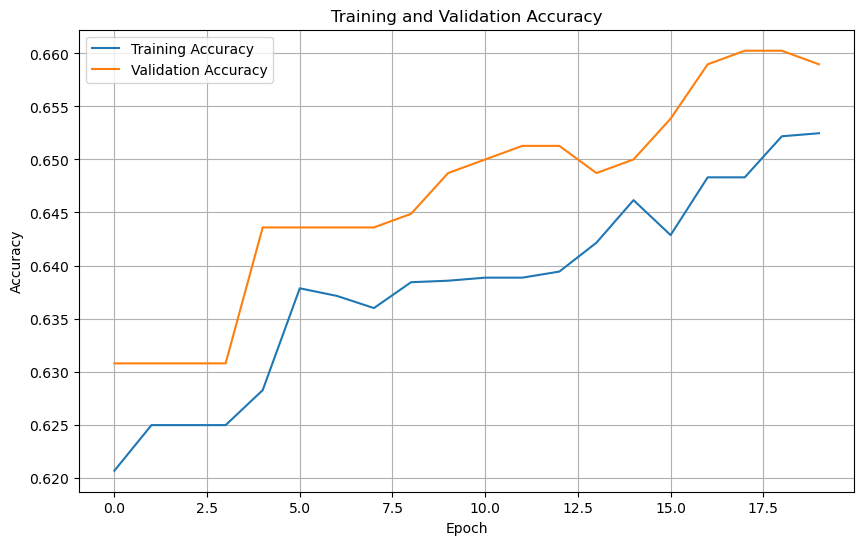

In [18]:
import matplotlib.pyplot as plt

# Train the model and capture the training history
#history = model.fit([X_train_padded, X_train_padded], y_train_padded, epochs=20, batch_size=32, validation_split=0.2)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

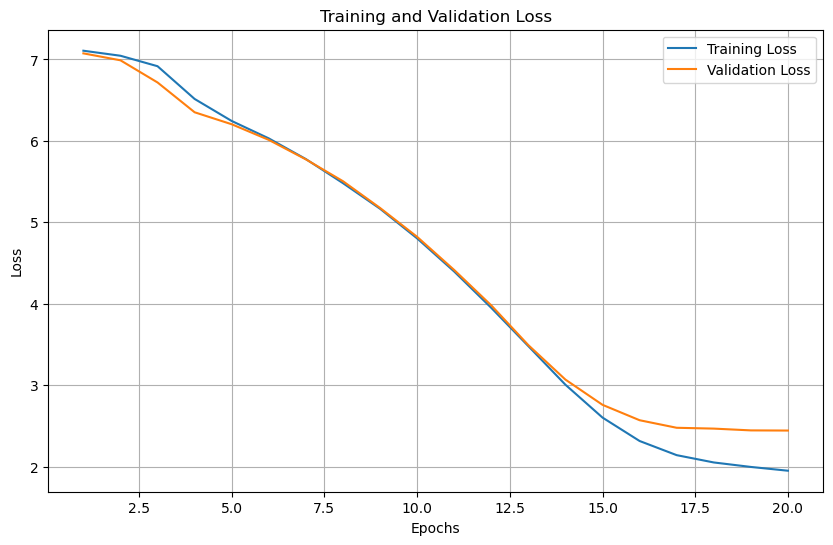

In [19]:
import matplotlib.pyplot as plt

# Access training history from the 'history' object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()